In [1]:
import transformers
from datasets import Dataset
import evaluate

import pandas as pd
import torch
import logging
import glob
import os

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

/home/mp/anaconda3/envs/mlops/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-08 14:08:20.960299: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 14:08:20.960328: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 14:08:20.961982: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 14:08:21.134685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow b

In [2]:
df = pd.read_csv('data/processed/AITA-Reddit-Dataset.csv')

In [4]:
# get last created file
checkpoint = glob.glob(os.path.join('results','*'))
checkpoint.sort(key=os.path.getmtime)
# chkpt = checkpoint[-1]

chkpt = None

In [6]:
model_name = 'bert-base-uncased'

if chkpt is not None:
    model = transformers.BertForSequenceClassification.from_pretrained(chkpt, num_labels=4, problem_type='multi_label_classification').to('cuda')
else:
    model = transformers.BertForSequenceClassification.from_pretrained(model_name, num_labels=4, problem_type='multi_label_classification').to('cuda')

tokenizer = transformers.BertTokenizer.from_pretrained(model_name, problem_type='multi_label_classification')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
classifier = transformers.pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device='cpu')

In [8]:
# Create Dataset
base_dataset = Dataset.from_pandas(df)

# Vectorize labels
cols = base_dataset.column_names
base_dataset = base_dataset.map(lambda x: {'labels': [x[c] for c in cols if c != "text"]})

/home/mp/anaconda3/envs/mlops/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [9]:
# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize the data (only keep relevant columns)
cols = base_dataset.column_names
cols.remove('labels')
dataset = base_dataset.select(range(1000)).map(tokenize_function, batched=True, remove_columns=cols)

In [10]:
# Create a dataset class with LABEL and TEXT columns
dataset = dataset.train_test_split(test_size=0.2)
validation_test_dataset = dataset['test'].train_test_split(test_size=0.5)
dataset['validation'] = validation_test_dataset['train']
dataset['test'] = validation_test_dataset['test']


In [11]:
# Model evaluation
f1 = evaluate.load('f1')

# logging.basicConfig(level=logging.INFO, filename='example.log')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels)

In [12]:
# finetune the model
training_args = transformers.TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=1,   # batch size per device during training
    per_device_eval_batch_size=1,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=500,
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
)
trainer.train()
    

 13%|█▎        | 101/800 [00:09<01:01, 11.46it/s]

{'loss': 0.5467, 'learning_rate': 1e-05, 'epoch': 0.12}


 25%|██▌       | 201/800 [00:17<00:52, 11.37it/s]

{'loss': 0.3148, 'learning_rate': 2e-05, 'epoch': 0.25}


 38%|███▊      | 301/800 [00:26<00:43, 11.55it/s]

{'loss': 0.3317, 'learning_rate': 3e-05, 'epoch': 0.38}


 50%|█████     | 401/800 [00:35<00:34, 11.56it/s]

{'loss': 0.3555, 'learning_rate': 4e-05, 'epoch': 0.5}


 62%|██████▎   | 500/800 [00:43<00:26, 11.46it/s]

{'loss': 0.3311, 'learning_rate': 5e-05, 'epoch': 0.62}


                                                 
 62%|██████▎   | 500/800 [00:45<00:26, 11.46it/s]

{'eval_loss': 0.47869673371315, 'eval_runtime': 2.0184, 'eval_samples_per_second': 49.545, 'eval_steps_per_second': 49.545, 'epoch': 0.62}


 75%|███████▌  | 601/800 [00:56<00:17, 11.50it/s]

{'loss': 0.3365, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.75}


 88%|████████▊ | 701/800 [01:04<00:08, 11.47it/s]

{'loss': 0.3058, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.88}


100%|██████████| 800/800 [01:13<00:00, 10.90it/s]

{'loss': 0.3134, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 73.3836, 'train_samples_per_second': 10.902, 'train_steps_per_second': 10.902, 'train_loss': 0.35443567752838134, 'epoch': 1.0}


TrainOutput(global_step=800, training_loss=0.35443567752838134, metrics={'train_runtime': 73.3836, 'train_samples_per_second': 10.902, 'train_steps_per_second': 10.902, 'train_loss': 0.35443567752838134, 'epoch': 1.0})

In [13]:
predictions = trainer.predict(dataset['test'])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 49.23it/s]


In [14]:
predictions.predictions

array([[-7.002139 , -7.083475 ,  3.8731327, -3.949504 ],
       [-7.006008 , -7.07641  ,  3.7907   , -3.837818 ],
       [-7.0121355, -7.080845 ,  3.795226 , -3.84762  ],
       [-6.994981 , -7.067391 ,  3.7289288, -3.7750533],
       [-7.0061736, -7.0898833,  3.8661487, -3.9357936],
       [-7.0073843, -7.0737653,  3.7847054, -3.8342621],
       [-7.006998 , -7.0679708,  3.7751987, -3.8277297],
       [-7.0180507, -7.087995 ,  3.758873 , -3.8084047],
       [-7.0070076, -7.070346 ,  3.7931278, -3.8386497],
       [-7.009458 , -7.071921 ,  3.7497194, -3.8039021],
       [-7.025654 , -7.108991 ,  3.8677208, -3.9422407],
       [-7.0161324, -7.117451 ,  3.8623035, -3.932753 ],
       [-7.0213394, -7.090322 ,  3.7920759, -3.8395913],
       [-7.056844 , -7.141958 ,  3.805708 , -3.8776271],
       [-6.9952927, -7.061849 ,  3.768708 , -3.832042 ],
       [-7.0003357, -7.063867 ,  3.7795594, -3.8376496],
       [-7.0196705, -7.092177 ,  3.7968957, -3.8462658],
       [-7.011591 , -7.076856 ,

In [21]:
predictions.label_ids.argmax(-1)    

array([2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3])

In [28]:
predictions.label_ids.argmax(-1)

array([2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3])

In [30]:
cm

array([[81,  0],
       [19,  0]])

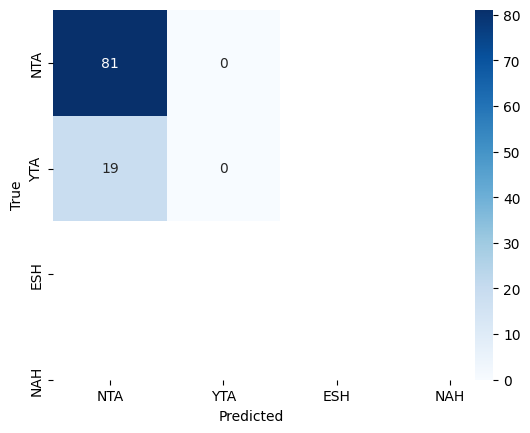

In [29]:
# sns confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(predictions.label_ids.argmax(-1), predictions.predictions.argmax(-1))

class_labels = ['NTA', 'YTA', 'ESH', 'NAH']

# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()